In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
import matplotlib as mpl

In [3]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.formula.api import ols

In [4]:
from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

In [5]:
from shapely import wkt

In [6]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d35 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_35.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

In [7]:
ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

In [8]:
fifty_seven = pd.read_csv('../data/fifty_seventh_assem.csv')
fifty_seven = fifty_seven[['aded','percphara','percmos']]
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')

full_results_thirty_five = full_results[full_results['district'] == 35]
mh_full = full_results[full_results['candidate'] ==  'Michael Hollingsworth']
ch_full = full_results[full_results['candidate'] ==  'Crystal Hudson']
mh_full = mh_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]
ch_full = ch_full[['vote_share','ed_name','dpp20bs','garcia213p','white_transplant_ratio','mhhi21','cvap21bapp','h21p', 'nha21p', 'nhb21p', 'nhw21p','wfh_ratio']]
mh_ps = fifty_seven.merge(mh_full, left_on = 'aded', right_on = 'ed_name')
mh_ps['dpp20bs'] = mh_ps['dpp20bs'] / 10
mh_ps['hol_phar_diff'] = mh_ps['percphara'] - mh_ps['vote_share']

In [9]:
dif_map = mh_ps.merge(ed_gdf, left_on = 'aded', right_on = 'ElectDist') 

In [10]:
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')

In [11]:
d35 = make_edname(d35)
d35_eds = d35['ed_name'].unique().tolist()

The 2021 Democratic primary in Brooklyn’s 35th City Council district offered an excellent view of a rivalry central to NYC progressive politics. Crystal Hudson, aid to the former city council woman, squared off against Michael Hollingsworth, DSA-endorsed socialist, in a contest that tested the appeal of two of the cities left factions in one of its more diverse districts. Because of the perceived ideological division between the candidates and the diversity of the district, it promised an especially salient view of how different brands of progressive politics appeal to different demographics. Additionally, the district’s large Hasidic population offered a chance to analyze how progressive candidates deal with powerful, conservative voting blocs within their districts. This chapter will examine the demographics of the district, look at the election results, compare this election with similar assembly election in many of the same EDs, and conclude with some lessens that these races offer for progressive politics in the city. 

## The District

District 35 lies in Central Brooklyn, running down Flatbush Avenue through Prospect Heights and then East through Crown Heights with Empire Boulevard as its southern border. The district falls in the top quintile of NYC Council districts in rate of higher education and in the second highest in both White and Black share of the population. Much of the Black population is of West Indian origin, it is in the top quintile West Indian born residents. It is also in the top quintile of white population born outside of New York State, and many of its neighborhoods, fairly or not, have the reputation of being rapidly gentrifying. It has a sizeable Hasidic population, the Chabad-Lubavitch, though this population is partially split with the 4oth Council District. It has low Asian and Hispanic populations, and is in the middle of the road in terms of income, though this masks much diversity.  The high rates of education and middle-income district wide numbers can be deceiving, with certain election districts (EDs) in the 35th among the poorest and least educated in the city. In the demographic clustering used in chapter two it was in cluster three, with districts such as Lincoln Restler's and Shahana Hanif's, that mix high-income, mainly white sections, with more racially diverse and mid- and lower-income sections. The district is heavily Democratic. The congressional district in which it sits, the New York 9th, is D+32 on the Cook Political Index. Joe Biden won the 35th by an 85% margin (though there was significant Trump support in the Hassidic section of the neighborhood). 

Figure 1 below is a map of education level by election district in the council district. Of note are the generally higher levels of education north of Grand Army Plaza in the Prospect Heights area, with the exception of the top hook of the district which includes a NYCHA campus. Income is similarly much higher in the section of the neighborhood. 

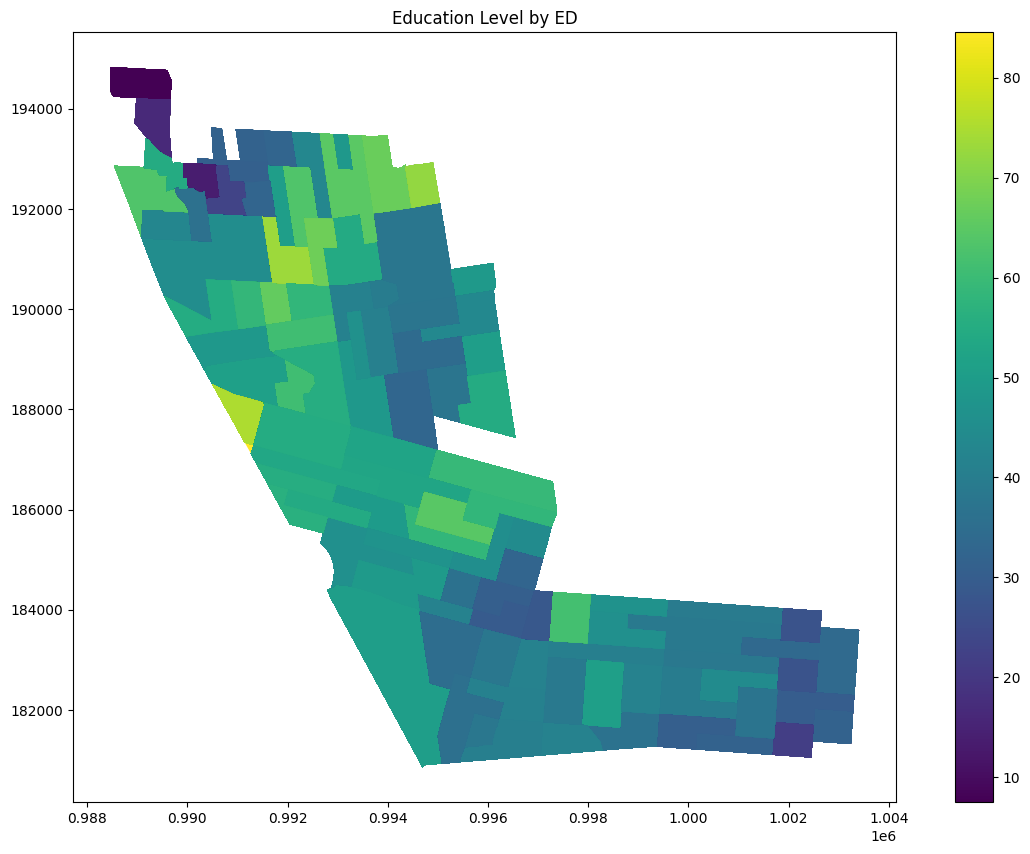

In [ ]:
#| warning: false
demo_map = make_demo_map(d35,ed_level)
demo_map.plot(column='cvap21bapp', cmap='viridis', legend=True, figsize=(15, 10))
plt.title("Education Level by ED")
plt.show()

In [13]:
winners = full_results_thirty_five[full_results_thirty_five['winner'] == True]
winners = winners.merge(occ_df,left_on='ed_name',right_on='ElectDist',how='left')

In [51]:
tdc = ['w2oadp','w2hsp','w2admp','w2psp','w2mgtp','w2npp','w2salep','w2admp','w2cossp','w2edup']

In [21]:
winners[wp_cols].std().nlargest(10)

w2hsp        8.439066
w2oadp       8.389907
w2psp        7.944433
w2admp       6.138079
w2mgtp       5.334292
w2npp        5.116698
w2salep      5.065444
w2pservep    4.279274
w2govp       4.181816
w2conp       4.037600
dtype: float64

In [8]:
clusters = scale_and_cluster(d35,ed_level,cols_to_keep,5)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]

In [13]:
cols_to_keep = ['mhhi21', 'nhb21p', 'nhw21p','cvap21bapp']
cols_to_keep.extend(wp_cols)

In [72]:
demo_map = mh_full.merge(ed_gdf, left_on = 'ed_name', right_on = 'ElectDist')
demo_map = gpd.GeoDataFrame(demo_map)

In [14]:
cluster_df = mh_full[['ed_name','white_transplant_ratio']].merge(ed_level, left_on = 'ed_name', right_on = 'ElectDist')
cluster_df = cluster_df.merge(occ_df, left_on = 'ed_name', right_on = 'ElectDist')
df = cluster_df[cols_to_keep]

In [15]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 1.0, 'Elbow Method')

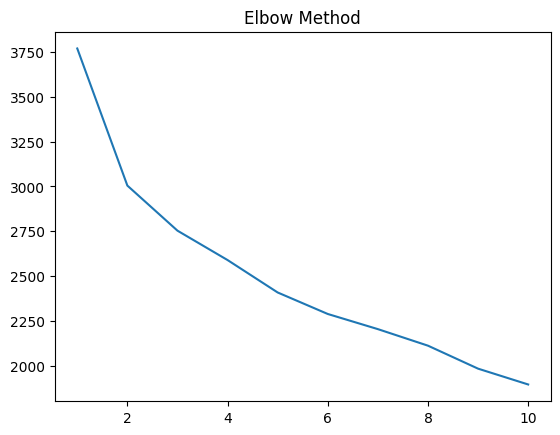

In [75]:
#elbow plot
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')

In [16]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(df_scaled)
cluster_df['cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
cluster_df.groupby('cluster')[['mhhi21', 'nhb21p', 'nhw21p','cvap21bapp','w2admp','w2cmp','w2mgtp','w2pservep',
 'w2salep',
 'w2oadp']].mean().round(2)

,mhhi21,nhb21p,nhw21p,cvap21bapp,w2admp,w2cmp,w2mgtp,w2pservep,w2salep,w2oadp
cluster,,,,,,,,,,
0,59866.63,28.50,30.92,47.47,13.82,7.02,16.01,3.20,10.89,15.25
1,37161.50,38.85,12.71,22.51,2.30,3.15,6.03,13.53,8.96,19.54
2,36158.18,42.82,21.85,37.03,9.90,4.89,10.77,7.63,8.85,20.81
3,43117.29,21.03,29.81,37.86,5.34,0.85,5.34,12.52,7.93,21.91
4,134508.21,14.83,46.12,56.95,15.87,6.58,17.53,4.81,15.21,7.81
5,61410.60,28.59,50.18,39.82,6.08,3.03,13.45,4.80,13.04,28.40


In [97]:
mean_values = cluster_df.groupby("cluster")[wp_cols].mean() 
diffs = (mean_values.loc[1] - mean_values.loc[3]).abs() 
top_diff_col = diffs.idxmax()  
top_10_diff_cols = diffs.nlargest(10)
print(top_10_diff_cols)

w2hsp      15.934185
w2ffp       6.317671
w2scip      6.244136
w2foodp     6.242060
w2tranp     4.493580
w2htp       3.298515
w2copp      3.195321
w2admp      3.036241
w2emrp      2.366751
w2oadp      2.363940
dtype: float64


In [20]:
cluster_df_map = cluster_df.merge(ed_gdf, left_on = 'ed_name', right_on = 'ElectDist')
cluster_df_map = gpd.GeoDataFrame(cluster_df_map)

Text(0.5, 1.0, 'Clusters by ED')

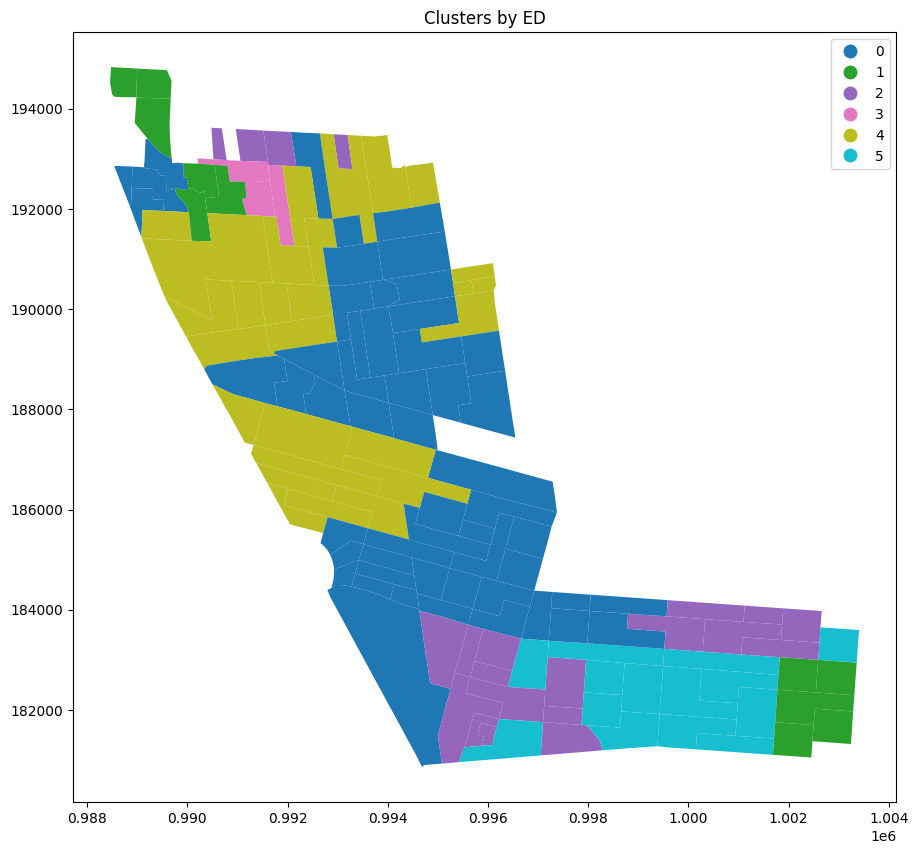

In [21]:
cluster_df_map['cluster'] = cluster_df_map['cluster'].astype('category')
cluster_df_map.plot(column='cluster', cmap='tab10', legend=True, figsize=(15, 10))
plt.title("Clusters by ED")

In [148]:
averages = clusters.groupby('cluster')[cols_to_keep].mean().reset_index()
averages['top_three'] = averages[job_cols].apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
averages[['cluster','mhhi21','cvap21bapp','white_transplant_ratio','nhb21p','Retail Trade','Professional, Scientific, and Technical Services','Educational Services','Information']].round(2)

,cluster,mhhi21,cvap21bapp,white_transplant_ratio,nhb21p,Retail Trade,"Professional, Scientific, and Technical Services",Educational Services,Information
0,0,45493.21,49.64,21.84,33.55,9.45,10.53,6.62,6.28
1,1,44883.61,40.59,15.31,45.81,10.95,7.94,4.59,4.45
2,2,116296.63,57.24,21.96,14.75,8.61,12.18,8.48,6.95
3,3,56919.96,31.45,10.73,29.77,11.37,7.61,5.66,4.17
4,4,55567.20,38.61,9.33,27.35,11.19,7.28,8.58,3.73


In [150]:
from IPython.display import Latex

In [ ]:
averages = clusters.groupby('cluster')[cols_to_keep].mean().reset_index()
averages['top_three'] = averages[job_cols].apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
a_tbl = averages[['cluster','mhhi21','cvap21bapp','white_transplant_ratio','nhb21p','Retail Trade','Professional, Scientific, and Technical Services','Educational Services','Information']].round(2)
a_tbl = a_tbl.rename(columns={'mhhi21':'MHI','cvap21bapp':'BA+','nhb21p':"NH Black",'Retail Trade':'Retail','Professional, Scientific, and Technical Services':'Science & Tech','Educational Services':'Education','Information':'Information'})
a_tbl

,cluster,MHI,BA+,white_transplant_ratio,NH Black,Retail,Science & Tech,Education,Information
0,0,45493.21,49.64,21.84,33.55,9.45,10.53,6.62,6.28
1,1,44883.61,40.59,15.31,45.81,10.95,7.94,4.59,4.45
2,2,116296.63,57.24,21.96,14.75,8.61,12.18,8.48,6.95
3,3,56919.96,31.45,10.73,29.77,11.37,7.61,5.66,4.17
4,4,55567.20,38.61,9.33,27.35,11.19,7.28,8.58,3.73


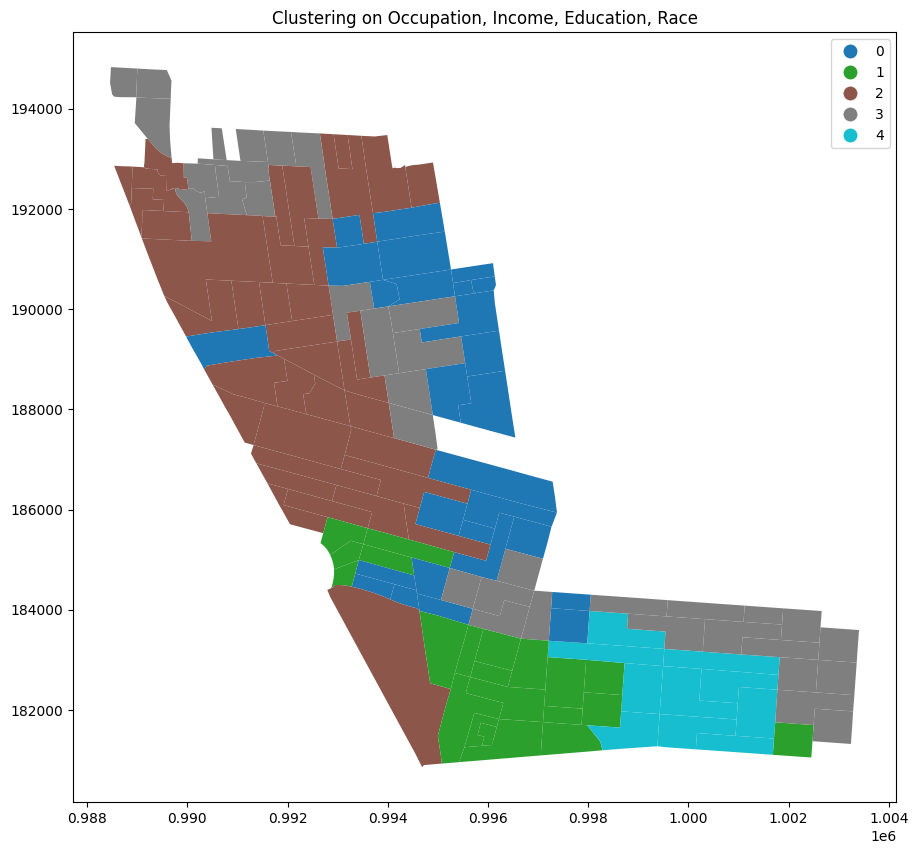

In [157]:
#| warning: false

df_gdf = clusters.merge(ed_gdf, on='ElectDist', how='left')
df_gdf = gpd.GeoDataFrame(df_gdf)

df_gdf['cluster'] = df_gdf['cluster'].astype('category')
df_gdf.plot(column='cluster', cmap='tab10', legend=True, figsize=(15, 10))
plt.title("Clustering on Occupation, Income, Education, Race")
plt.show()

## The Candidates

The two front runners in the 2021 Council race were Crystal Hudson and Michael Hollingsworth. Hudson had previously worked for the outgoing member Laurie Cuombo, and therefore had connections the county party and city Democratic establishment, whereas Holligsworth, a graphic designer and organizer, proudly ran on his lack of such connections. Despite these differences, both candidate vied for a DSA endorsement, signaling an extensive ideological overlap. Indeed, in analyzing their interviews, tweets, and campaign material, it is difficult to find significant daylight between the two on firm policy issues. Indeed, much media commentary noted two seemingly contradictory aspects of the race, that 1: it set up a contest between two rival sections of the city’s progressive left, but that 2: the two candidates seemed to agree on most substantive policy issues [@Hamm 2021; @Barkan 2021; @Smith 2021; @Salazar 2021]. Both agreed that portions of the NYPD’s budget should be reallocated to other uses, both thought the city’s rezoning process needed to be retooled to build more affordable housing, especially in wealthy neighborhoods, both were pro union and pro public school. One commentator suggested that there was some daylight between the candidates on real estate, with Hollingsworth suggesting a complete moratorium on upzonings, while Hudson argued that upzonings should continue, but in wealthier neighborhoods and with more affordable housing. Case in point, she supports the SoHo/NoHo rezoning while Hollingsworth does not (Oder 2021). Similarly, Hollingsworth has suggested he would continue to support the practice of local member deference, while Hudson would not [@Oder 2021]. Though this gap on real estate and development is not enormous, it may explain, in part, some of the union PAC support for Hudson as well as the Stephen Ross mailers mentioned below. 

Because of the symmetry in ideology and the asymmetry in endorsements, the 35th helps illuminate some particularly interesting dynamic in NYC progressive politics. How are DSA endorsements earned and how much power do they wield, especially against Brooklyn big hitters like Hakeem Jeffries? During her term in office Laurie Cuombo, while taking heat for her relationship with real estate developers, reffered to the DSA as being the political wing of white gentrification. Does that analysis hold out in the 3fth? What groups do these endorsements appeal to? Who might they discourage? At the root of these questions are larger ones about political branding as well as about how national politics map onto local politics.

Table 1 shows the flow of votes in the fist two rounds of voting, ranked by number of ballots. The top two options where overwhelmingly one of the top two followed by the other. Nonetheless there are many ballots who chose Hudson and then someone else second, and fewer though still a substantial amount that chose HOllingsworth and not Hudson. 

In [13]:
d35.groupby('district_35_choice_1')['district_35_choice_2'].value_counts().reset_index(name='count').sort_values('count', ascending=False).head(10)

,district_35_choice_1,district_35_choice_2,count
34,Michael Hollingsworth,Crystal Hudson,5900
0,Crystal Hudson,Michael Hollingsworth,5068
1,Crystal Hudson,Hector Robertson,1842
2,Crystal Hudson,Renee T. Collymore,1772
35,Michael Hollingsworth,Renee T. Collymore,1184
52,Renee T. Collymore,Crystal Hudson,1038
53,Renee T. Collymore,Michael Hollingsworth,832
3,Crystal Hudson,Curtis M. Harris,574
4,Crystal Hudson,Deirdre M. Levy,516
36,Michael Hollingsworth,Curtis M. Harris,493


Figure 1 shows how these voting flows break geographically. The largest section of Hudson voters who did not list Hollingsworth next live in the primarily Hasidic part of the neighborhood. Holingsworth had tremendous trouble with the community, which is discussed below. Communities that voted Hudson and then Holingswroth are clustered in the wealthier area along Flatbush avenue. 

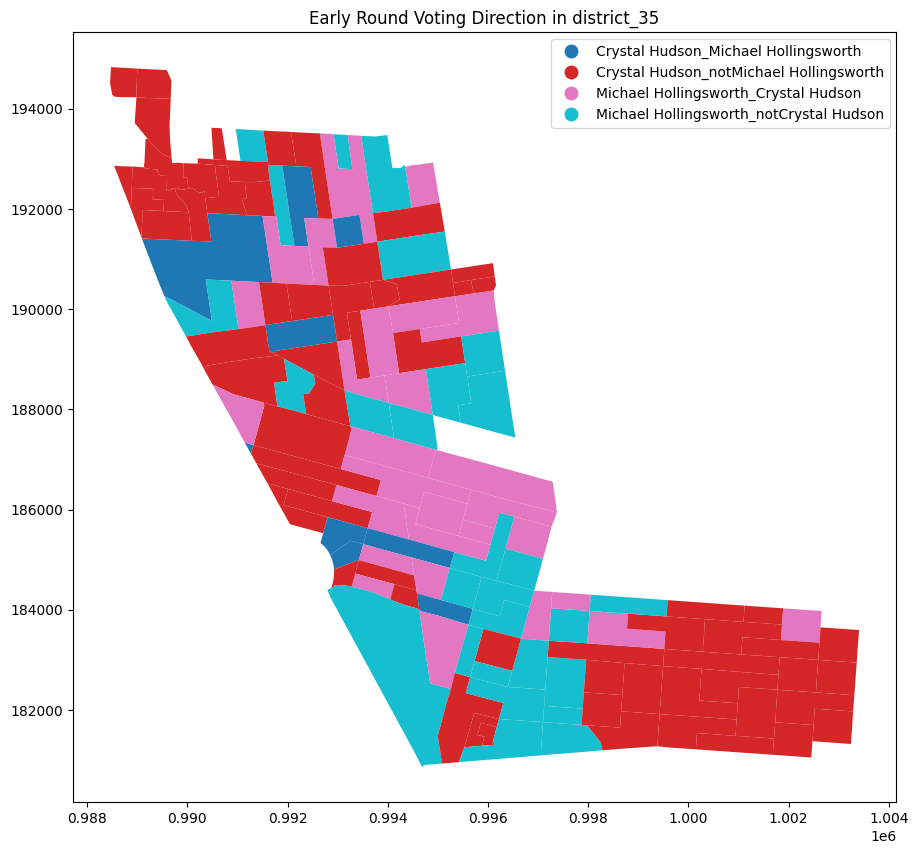

In [64]:
map_round_votes(d35,ed_gdf,'district_35','Crystal Hudson','Michael Hollingsworth')

When compared with the overall first round results is becomes clear Hudson's strongest area of the district were the Hasidic neighborhoods, which is striking. In addition to Hudson’s already mentioned progressive policy position, she is also a lesbian, and campaigned on the necessity of having more Black queer representation in the City Council. That one of the city’s most conservative religious blocs would concentrate in such heavy numbers for her is, at least at first glance, surprising. A dive into the Hassidic press helps to clarify this seeming contradiction. In multiple articles across multiple publications, Michael Hollingsworth is described as fiercely antisemitic, primarily because of his stance on the state of Israel. One ColLive article begins “Socialist representation of Crown Heights? A BDS supporter as your City Council member? Jewish concerns shelved? Yep. And all you have to do is ignore the coming June 22 election” [@Behrman and Klein, 2021]. Many articles feature pro-Palestinian tweets either he or the DSA made as evidence of his antisemitism. One features a cartoon video of Hollingsworth standing in front of a burning Israeli flag (Anash June10, 2021). Much more is made of his stance towards Israel than of his position on local issues, such as monitoring of educational standards at Yeshivas (though one flyer does implore the voter to “protect our Yeshivas” by voting Hudson). Hudson is not generally described in positive terms in these articles, except to say that she is not affiliated with BDS or DSA and that she has a dialogue with the community. The principle selling point for her was that she was the only candidate capable of beating Hollingsworth. “Internal polls show that no other candidates have a chance at victory” one article reads, after smearing Hollingsworth, “this race is between Crystal and Michael only” (Behrman and Klein, 2021). According to self-reported numbers, the Hassidic community turned out at 7 times its normal rate in the June primary, producing 4,000 votes, or almost twice Crystal Hudson’s margin of victory [@Weissman 2021, @Anash June 24, 2021]. 

## The DSA Factor 

A year before the Council primary in the 35th Phara Soufrant Forest, a DSA endorsed candidate won the primary and general election in the 57th Assembly District. This district covers the majority of the 35th Council District but ends along Franklin Boulevard, meaning that it excludes the Hasidic parts of the neighborhood. This overlap allows allows us to zoom in specifically on the question of how left-wing candidates form coalitions in the district, excluding the tricky question of the Hasidic community. It also allows us to crudely control for the DSA effect on the vote, seeing what broke differently for Hudson and Hollingsworth than Forrest and opponent Walter T. Mosely. 

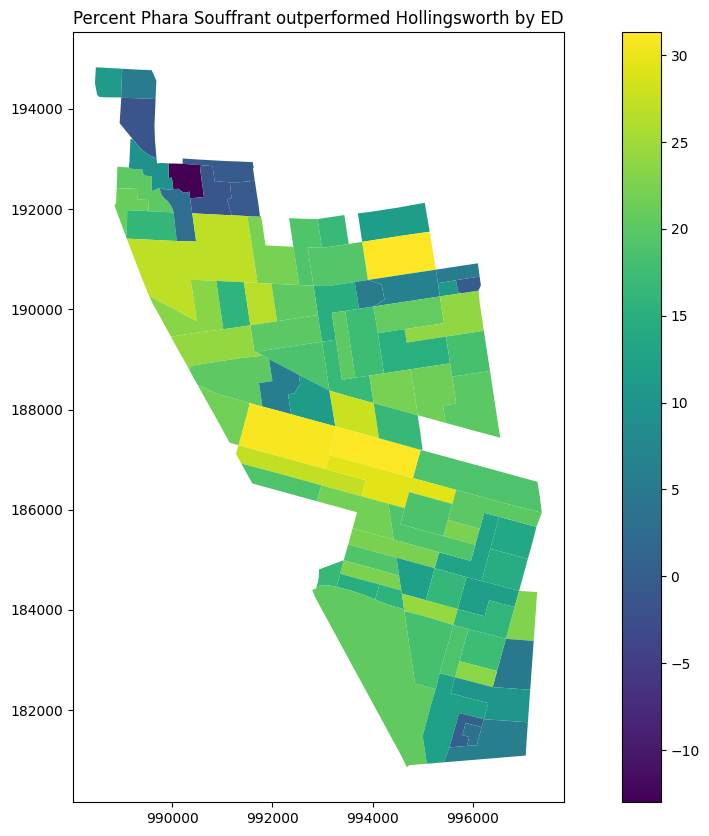

In [41]:
dif_map = gpd.GeoDataFrame(dif_map)
dif_map.plot(column='hol_phar_diff', cmap='viridis', legend=True, figsize=(15, 10))
plt.title("Percent Phara Souffrant outperformed Hollingsworth by ED")
plt.show()

In [62]:
# make a new var that is the log of the median household income
mh_ps['log_mhhi21'] = np.log(mh_ps['mhhi21'])

In [64]:
target = mh_ps['hol_phar_diff']
mod1 = sm.OLS(target, sm.add_constant(mh_ps[['log_mhhi21']])).fit()
mod2 = sm.OLS(target, sm.add_constant(mh_ps[['log_mhhi21','cvap21bapp']])).fit()
mod3 = sm.OLS(target, sm.add_constant(mh_ps[['log_mhhi21','cvap21bapp', 'white_transplant_ratio']])).fit()

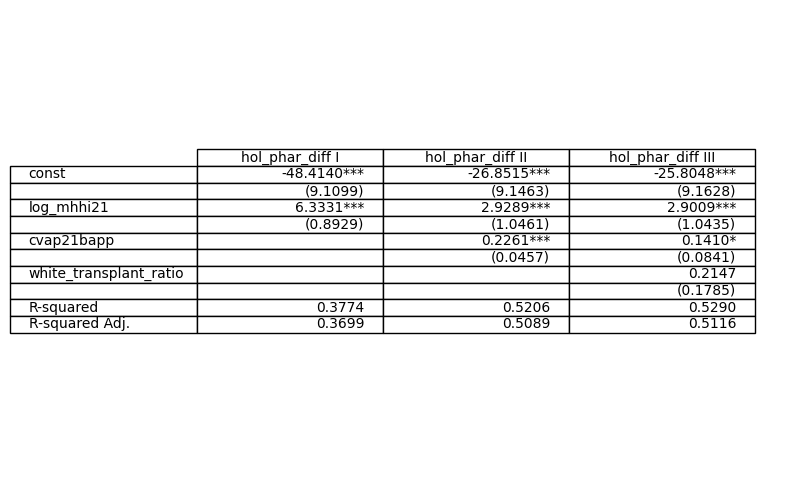

In [67]:
summary = summary_col([mod1, mod2, mod3], stars=True)

table_df = summary.tables[0]
cell_text = table_df.values.tolist()
row_labels = table_df.index.tolist()
col_labels = table_df.columns.tolist()

plt.figure(figsize=(8, 6))
plt.table(cellText=cell_text,
          rowLabels=row_labels,
          colLabels=col_labels,
          loc='center',
          colWidths=[0.3] * len(col_labels))
plt.axis('off')
plt.show()

In [1]:
from stargazer.stargazer import Stargazer

In [ ]:
Stargazer([mod1, mod2, mod3]).render_latex()

In [65]:
summary_col([mod1,mod2,mod3], stars=True)

,hol_phar_diff I,hol_phar_diff II,hol_phar_diff III
const,-48.4140***,-26.8515***,-25.8048***
,(9.1099),(9.1463),(9.1628)
log_mhhi21,6.3331***,2.9289***,2.9009***
,(0.8929),(1.0461),(1.0435)
cvap21bapp,,0.2261***,0.1410*
,,(0.0457),(0.0841)
white_transplant_ratio,,,0.2147
,,,(0.1785)
R-squared,0.3774,0.5206,0.5290
R-squared Adj.,0.3699,0.5089,0.5116


brisport primary

In [39]:
colnames = ['a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j',
       'k', 
        'AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

good_cols = ['AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

In [38]:
jb = pd.read_csv('../data/brisport_primary.csv',header=None, names=colnames)
jb = jb[good_cols]

NameError: name 'colnames' is not defined

In [38]:
jb['precinct'] = 'AD: ' + jb['AD'].astype(str) + ' ' + 'ED: ' + jb['ED'].astype(str).str.zfill(3)
jb['ed_name'] = jb['AD'].astype(str) + jb['ED'].astype(str).str.zfill(3)

In [46]:
candidates = ['Jabari Brisport','Tremaine S. Wright','Jason Salmon']

In [50]:
jb_cand = jb[jb['Unit Name'].isin(candidates)]
jb_cand = jb_cand[['precinct','ed_name','Unit Name','Tally']]

In [ ]:
jb_cand = jb[jb['Unit Name'].isin(candidates)]
jb_cand = jb_cand[['precinct','ed_name','Unit Name','Tally']]
jb_cand.columns = ['precinct','ed_name','candidate','votes']
jb_cand['ed_total'] = jb_cand.groupby('ed_name')['votes'].transform('sum')
jb_cand['vote_share'] = round(jb_cand['votes'] / jb_cand['ed_total'] * 100,2)
jb_cand['vote_share'] = pd.to_numeric(jb_cand['vote_share'], errors='coerce')
max_vote_share_candidates = jb_cand.loc[jb_cand.groupby('ed_name')['vote_share'].idxmax()]

In [58]:
jb_cand['ed_total'] = jb_cand.groupby('ed_name')['votes'].transform('sum')
jb_cand['vote_share'] = round(jb_cand['votes'] / jb_cand['ed_total'] * 100,2)

In [86]:
jb_cand['vote_share'] = pd.to_numeric(jb_cand['vote_share'], errors='coerce')

In [90]:
jb_cand.dropna(inplace=True)


In [91]:
max_vote_share_candidates = jb_cand.loc[jb_cand.groupby('ed_name')['vote_share'].idxmax()]

In [ ]:
def read_noncc_votes(filepath,colnames,good_cols):
    df = pd.read_csv(filepath,header=None, names=colnames)
    df = df[good_cols]
    df['precinct'] = 'AD: ' + df['AD'].astype(str) + ' ' + 'ED: ' + df['ED'].astype(str).str.zfill(3)
    df['ed_name'] = df['AD'].astype(str) + df['ED'].astype(str).str.zfill(3)
    return df
def make_vote_share(df,candidates):
    df_cand = df[df['Unit Name'].isin(candidates)]
    df_cand = df_cand[['precinct','ed_name','Unit Name','Tally']]
    df_cand.columns = ['precinct','ed_name','candidate','votes']
    df_cand['ed_total'] = df_cand.groupby('ed_name')['votes'].transform('sum')
    df_cand['vote_share'] = round(df_cand['votes'] / df_cand['ed_total'] * 100,2)
    df_cand['vote_share'] = pd.to_numeric(df_cand['vote_share'], errors='coerce')
    max_vote_share_candidates = df_cand.loc[df_cand.groupby('ed_name')['vote_share'].idxmax()]
    return max_vote_share_candidates

In [ ]:
def make_vote_share(df,candidates):
    df_cand = df[df['Unit Name'].isin(candidates)]
    df_cand = df_cand[['precinct','ed_name','Unit Name','Tally']]
    df_cand.columns = ['precinct','ed_name','candidate','votes']
    df_cand['ed_total'] = df_cand.groupby('ed_name')['votes'].transform('sum')
    df_cand['vote_share'] = round(df_cand['votes'] / df_cand['ed_total'] * 100,2)
    df_cand['vote_share'] = pd.to_numeric(df_cand['vote_share'], errors='coerce')
    max_vote_share_candidates = df_cand.loc[df_cand.groupby('ed_name')['vote_share'].idxmax()]
    return max_vote_share_candidates

In [130]:
max_vote_share_candidates.to_csv('../data/max_vote_share_candidates.csv',index=False)

In [26]:
max_vote_share_candidates = pd.read_csv('../data/max_vote_share_candidates.csv')

In [27]:
tj = max_vote_share_candidates[['ed_name','candidate']]

In [60]:
brisport_primary = jb_cand[jb_cand['candidate'] == 'Jabari Brisport']

In [61]:
brisport_primary.to_csv('../data/brisport_primary.csv',index=False)

In [28]:
tj['ed_name'] = tj['ed_name'].astype('Int64')

C:\Users\samtg\AppData\Local\Temp\ipykernel_3680\780601645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tj['ed_name'] = tj['ed_name'].astype('Int64')


In [29]:
quick_compare = mh_ps.merge(tj, on='ed_name', how='left')

In [30]:
eds_won = full_results_thirty_five[full_results_thirty_five['winner'] == True]
eds_won = eds_won[['ed_name','candidate']]
eds_won.columns = ['ed_name','council']

In [31]:
quick_compare = quick_compare.merge(eds_won, on='ed_name', how='left')

In [32]:
quick_compare['assembley'] = quick_compare[['percmos','percphara']].apply(lambda x: x.idxmax(), axis=1)

In [33]:
quick_compare.dropna(inplace=True)

In [34]:
quick_compare[['ed_name','assembley','council','candidate']].groupby(['assembley','council','candidate']).count()

ed_name
assembley council               candidate                  
percmos   Crystal Hudson        Jabari Brisport          15
                                Tremaine S. Wright        7
          Michael Hollingsworth Jabari Brisport           2
                                Tremaine S. Wright        1
          Renee T. Collymore    Tremaine S. Wright        2
percphara Crystal Hudson        Jabari Brisport          11
          Michael Hollingsworth Jabari Brisport          21

In [49]:
quick_compare[['ed_name','assembley','council','candidate']].head(5)

,ed_name,assembley,council,candidate
0,57001,percmos,Crystal Hudson,Jabari Brisport
1,57002,percmos,Crystal Hudson,Tremaine S. Wright
2,57003,percmos,Crystal Hudson,Jabari Brisport
3,57006,percmos,Renee T. Collymore,Tremaine S. Wright
4,57007,percmos,Crystal Hudson,Tremaine S. Wright


In [35]:
quick_compare["missed_chance"] = np.where(
    (quick_compare["assembley"] == "percphara") & 
    (quick_compare["council"] == "Crystal Hudson") & 
    (quick_compare["candidate"] == "Jabari Brisport"), 
    1, 0
)

quick_compare["never_dsa"] = np.where(
    (quick_compare["assembley"] == "percmos") & 
    (quick_compare["council"].isin(["Crystal Hudson", "Renee T. Collymore"])) & 
    (quick_compare["candidate"] == "Tremaine S. Wright"), 
    1, 0
)

conditions = [
    (quick_compare["assembley"] == "percphara") & 
    (quick_compare["council"] == "Crystal Hudson") & 
    (quick_compare["candidate"] == "Jabari Brisport"),
    
    (quick_compare["assembley"] == "percphara") & 
    (quick_compare["council"] == "Michael Hollingsworth") & 
    (quick_compare["candidate"] == "Jabari Brisport")
]

values = [1, 2] 
quick_compare["dsa_cats"] = np.select(conditions, values, default=0)

In [36]:
quick_compare["dsa_cats"].value_counts()

dsa_cats
0    27
2    21
1    11
Name: count, dtype: int64

In [55]:
map_missed = quick_compare[['ed_name','missed_chance','never_dsa',"dsa_cats"]].merge(ed_gdf, left_on='ed_name',right_on= 'ElectDist', how='left')
map_missed = gpd.GeoDataFrame(map_missed)

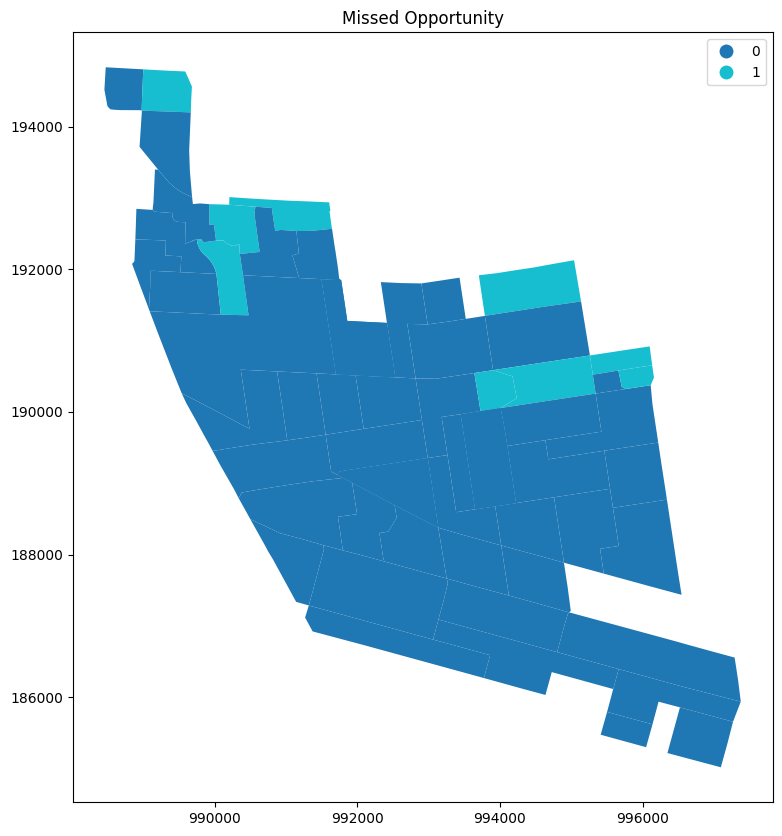

In [56]:
map_missed['never_dsa'] = map_missed['never_dsa'].astype('category')
map_missed.plot(column='never_dsa', cmap='tab10', legend=True, figsize=(15, 10))
plt.title("Missed Opportunity")
plt.show()

In [40]:
qc_demo = quick_compare[['ed_name','missed_chance','never_dsa',"dsa_cats"]].merge(full_results_thirty_five, on='ed_name', how='left')

In [38]:
full_results_thirty_five['dpp20bs'] = full_results_thirty_five['dpp20bs'] / 10

C:\Users\samtg\AppData\Local\Temp\ipykernel_3680\3063425536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_results_thirty_five['dpp20bs'] = full_results_thirty_five['dpp20bs'] / 10


In [41]:
qc_demo.groupby('missed_chance').agg({
    'nhw21p': 'mean',
    'white_transplant_ratio': 'mean',
    'mhhi21': 'mean',
    'cvap21bapp': 'mean',
    'wfh_ratio': 'mean',
    'dpp20bs': 'mean'

}).round(2)

,nhw21p,white_transplant_ratio,mhhi21,cvap21bapp,wfh_ratio,dpp20bs
missed_chance,,,,,,
0,36.61,18.32,33868.56,54.74,17.87,21.41
1,56.81,26.49,71909.29,74.53,23.53,21.72


In [60]:
qc_demo.groupby('never_dsa').agg({
    'nhw21p': 'mean',
    'white_transplant_ratio': 'mean',
    'mhhi21': 'mean',
    'cvap21bapp': 'mean',
    'wfh_ratio': 'mean',
    'dpp20bs': 'mean'

}).round(2)

,nhw21p,white_transplant_ratio,mhhi21,cvap21bapp,wfh_ratio,dpp20bs
never_dsa,,,,,,
0,43.22,21.16,46317.7,62.69,19.91,222.92
1,24.88,12.69,11805.0,35.51,13.58,171.41


In [49]:
qc_demo_occ = qc_demo.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [52]:
qc_demo_occ.groupby('dsa_cats')[tdc].mean().round(2)

,w2oadp,w2hsp,w2admp,w2psp,w2mgtp,w2npp,w2salep,w2admp,w2cossp,w2edup
dsa_cats,,,,,,,,,,
0,15.12,14.31,9.21,62.67,12.75,13.64,11.70,9.21,1.37,6.13
1,8.85,3.09,15.73,57.68,17.60,13.59,14.16,15.73,1.80,7.66
2,13.01,5.05,18.71,60.26,17.37,14.52,12.06,18.71,1.72,7.51


In [54]:
dep_vars = ['nhw21p', 'nhb21p', 'white_transplant_ratio', 
            'mhhi21', 'cvap21bapp', 'wfh_ratio', 'dpp20bs', 
            'w2oadp', 'w2admp']

for dv in dep_vars:
    model = ols(f'{dv} ~ C(dsa_cats)', data=qc_demo_occ).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANOVA results for {dv}:")
    print(anova_table)



ANOVA results for nhw21p:
                   sum_sq     df           F        PR(>F)
C(dsa_cats)  65455.977094    2.0  195.567893  5.940926e-62
Residual     75808.859075  453.0         NaN           NaN

ANOVA results for nhb21p:
                   sum_sq     df           F        PR(>F)
C(dsa_cats)  13628.605122    2.0  103.221906  1.154707e-37
Residual     29905.270852  453.0         NaN           NaN

ANOVA results for white_transplant_ratio:
                   sum_sq     df           F        PR(>F)
C(dsa_cats)  14701.984558    2.0  171.354993  3.848385e-56
Residual     19433.337989  453.0         NaN           NaN

ANOVA results for mhhi21:
                   sum_sq     df           F        PR(>F)
C(dsa_cats)  1.727301e+11    2.0  165.832226  9.126865e-55
Residual     2.359214e+11  453.0         NaN           NaN

ANOVA results for cvap21bapp:
                    sum_sq     df           F        PR(>F)
C(dsa_cats)   76204.008481    2.0  143.484226  5.363546e-49
Residual     1202

In [65]:
mean_values = qc_demo_occ[qc_demo_occ['dsa_cats'].isin([1,2])].groupby('candidate')[wp_cols].agg("mean")
diffs = mean_values.max() - mean_values.min()
top_diff_cols = diffs.nlargest(10)  
print(top_diff_cols)

w2oadp     4.492242
w2admp     4.446910
w2salep    3.306776
w2psp      2.539716
w2banp     2.302933
w2hsp      2.106192
w2foodp    2.045451
w2cossp    1.937769
w2sep      1.706673
w2nip      1.266011
dtype: float64


In [61]:
qc_demo.groupby('dsa_cats').agg({
    'nhw21p': 'mean',
    'nhb21p': 'mean',
    'nhw21p': 'mean',
    'white_transplant_ratio': 'mean',
    'mhhi21': 'mean',
    'cvap21bapp': 'mean',
    'wfh_ratio': 'mean',
    'dpp20bs': 'mean'

}).round(2)

,nhw21p,nhb21p,white_transplant_ratio,mhhi21,cvap21bapp,wfh_ratio,dpp20bs
dsa_cats,,,,,,,
0,28.12,33.88,13.91,21953.08,45.01,16.11,165.75
1,56.81,19.46,26.49,71909.29,74.53,23.53,217.20
2,48.54,26.59,24.51,50627.12,68.41,20.33,282.13


In [131]:
max_vote_share_candidates = pd.read_csv('../data/max_vote_share_candidates.csv')
tj = max_vote_share_candidates[['ed_name','candidate']]

In [132]:
tj['ed_name'] = tj['ed_name'].astype('Int64')
quick_compare = mh_ps.merge(tj, on='ed_name', how='left')

C:\Users\samtg\AppData\Local\Temp\ipykernel_14668\465250901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tj['ed_name'] = tj['ed_name'].astype('Int64')


In [133]:
quick_compare

,aded,percphara,percmos,vote_share,ed_name,dpp20bs,garcia213p,white_transplant_ratio,mhhi21,cvap21bapp,h21p,nha21p,nhb21p,nhw21p,wfh_ratio,hol_phar_diff,log_mhhi21,candidate
0,57001,25.806452,74.193548,14.705882,57001,6.400000,10.657597,3.436849e-07,3289.267994,8.299522,46.446356,15.753735,36.985061,0.814849,7.227814,11.100569,8.098420,Jabari Brisport
1,57002,18.248175,81.751825,12.903226,57002,6.400001,10.657601,1.774516e-06,4188.585804,8.299527,46.446353,15.753735,36.985059,0.814853,7.227814,5.344949,8.340118,Tremaine S. Wright
2,57003,17.322835,81.889764,18.604651,57003,7.318217,16.800914,1.714005e+00,10580.835021,14.545063,42.626471,16.313356,36.219246,4.147891,9.094923,-1.281817,9.266800,Jabari Brisport
3,57006,21.904762,78.095238,22.222222,57006,9.001413,23.406736,4.971604e+00,12915.619250,20.698425,34.803908,7.458027,45.500430,7.824634,14.540656,-0.317460,9.466193,Tremaine S. Wright
4,57007,9.523810,90.476190,22.535211,57007,4.400000,17.725753,1.372998e-01,7706.648076,13.587786,16.338673,16.430206,49.153318,2.883295,0.000000,-13.011402,8.949839,Tremaine S. Wright
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,57097,16.129032,83.870968,16.470588,57097,26.200000,40.561798,1.439666e+01,4114.244171,43.515918,16.424565,7.766432,36.703581,35.869409,13.653242,-0.341556,8.322210,Tremaine S. Wright
81,57098,20.388350,79.611650,11.111111,57098,9.890675,40.066191,7.661887e+00,16806.010858,37.635684,20.547551,18.442356,37.182541,16.247447,13.389900,9.277238,9.729492,Jabari Brisport
82,57103,60.638298,39.361702,43.975904,57103,30.300001,59.773126,2.041150e+01,40655.016752,71.306213,4.722938,5.798457,28.922142,52.770635,18.806511,16.662394,10.612878,Jabari Brisport
83,57104,69.197397,30.585683,48.997773,57104,44.539650,57.681339,2.553189e+01,26066.892987,58.169611,13.245012,4.983755,34.465293,42.300917,18.774351,20.199624,10.168421,Jabari Brisport


In [55]:
ch_full.columns

Index(['Precinct', 'vote', 'total_vote_precinct', 'vote_share', 'ed_name',
       'winner', 'rank', 'district', 'candidate', 'matched_name',
       'kmode_cluster', 'member', 'ElectDist_x', 'ML4', 'ML6', 'ML5', 'ML2',
       'ML7', 'ML3', 'ML1', 'district_cluster', 'ElectDist_y', 'Shape_Leng',
       'Shape_Area', 'geometry', 'min_noise', 'max_noise',
       'summer_noise_complaints', 'min_arrests', 'max_arrests', 'density',
       'ldensity', 'p21own', 'p21rent', 'mhhi21', 'mean_noise', 'mean_arrests',
       'living_alone_ratio', 'same_sex_ratio', 'black_nys_ratio',
       'black_fb_ratio', 'white_transplant_ratio', 'femHHH_ratio',
       'drive_ratio', 'train_ratio', 'walk_ratio', 'bike_ratio', 'wfh_ratio',
       'bus_ratio', 'hh21olongp', 'h21p', 'nha21p', 'nhb21p', 'nhw21p',
       'mex21p', 'prican21p', 'domin21p', 'colomb21p', 'kor21p', 'chin21p',
       'venez21p', 'hh21op', 'hh21rc', 'range_of_arrests', 'range_of_noise',
       'cvap21bapp', 'rv21irp', 'rv21italp', 'pg20jrbp'

In [56]:
cor_cols = ['vote_share', 'mhhi21','cvap21bapp', 'dpp20bs','nhb21p', 'nhw21p','white_transplant_ratio',]

In [59]:
ch_full[cor_cols].corr().head(1)

,vote_share,mhhi21,cvap21bapp,dpp20bs,nhb21p,nhw21p,white_transplant_ratio
vote_share,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
cor_cols = ['vote_share','w2npp','nhw21p','w2cossp','w2edup','dpp20bs','nhb21p']
corr_df = ch_full.merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
corr_matrix = corr_df [cor_cols].corr()
corr_matrix = corr_matrix.sort_values('vote_share')

In [21]:
strongest = ['w2npp','nhw21p','w2cossp','w2edup','dpp20bs','nhb21p']

In [24]:
print(corr_matrix)

            vote_share     w2npp    nhw21p   w2cossp    w2edup   dpp20bs  \
dpp20bs      -0.291064  0.025871  0.333980 -0.210362  0.014061  1.000000   
nhb21p       -0.260613 -0.135519 -0.776997 -0.011114  0.076941 -0.246884   
w2edup        0.309283  0.281748  0.277372  0.306234  1.000000  0.014061   
w2cossp       0.387616  0.470139  0.188235  1.000000  0.306234 -0.210362   
nhw21p        0.523934  0.372040  1.000000  0.188235  0.277372  0.333980   
w2npp         0.528815  1.000000  0.372040  0.470139  0.281748  0.025871   
vote_share    1.000000  0.528815  0.523934  0.387616  0.309283 -0.291064   

              nhb21p  
dpp20bs    -0.246884  
nhb21p      1.000000  
w2edup      0.076941  
w2cossp    -0.011114  
nhw21p     -0.776997  
w2npp      -0.135519  
vote_share -0.260613  


In [70]:
full_results_thirty_five[full_results_thirty_five['candidate'].isin(['Crystal Hudson','Michael Hollingsworth'])][['ed_name','vote_share','candidate']].head(5)

,ed_name,vote_share,candidate
18224,43013,67.755102,Crystal Hudson
18225,43013,8.163265,Michael Hollingsworth
18233,43035,38.709677,Michael Hollingsworth
18234,43035,26.164875,Crystal Hudson
18241,43036,41.176471,Michael Hollingsworth


In [89]:
top_two = full_results_thirty_five[full_results_thirty_five['candidate'].isin(['Crystal Hudson','Michael Hollingsworth'])]
winners = top_two.loc[top_two.groupby('ed_name')['vote_share'].idxmax()].copy()

In [90]:
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [ ]:
def assign_color(row):
    if row['candidate'] == 'Crystal Hudson':
        return mpl.cm.Blues(row['norm'])
    else:
        return mpl.cm.Reds(row['norm'])

winners['color'] = winners.apply(assign_color, axis=1)

In [96]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

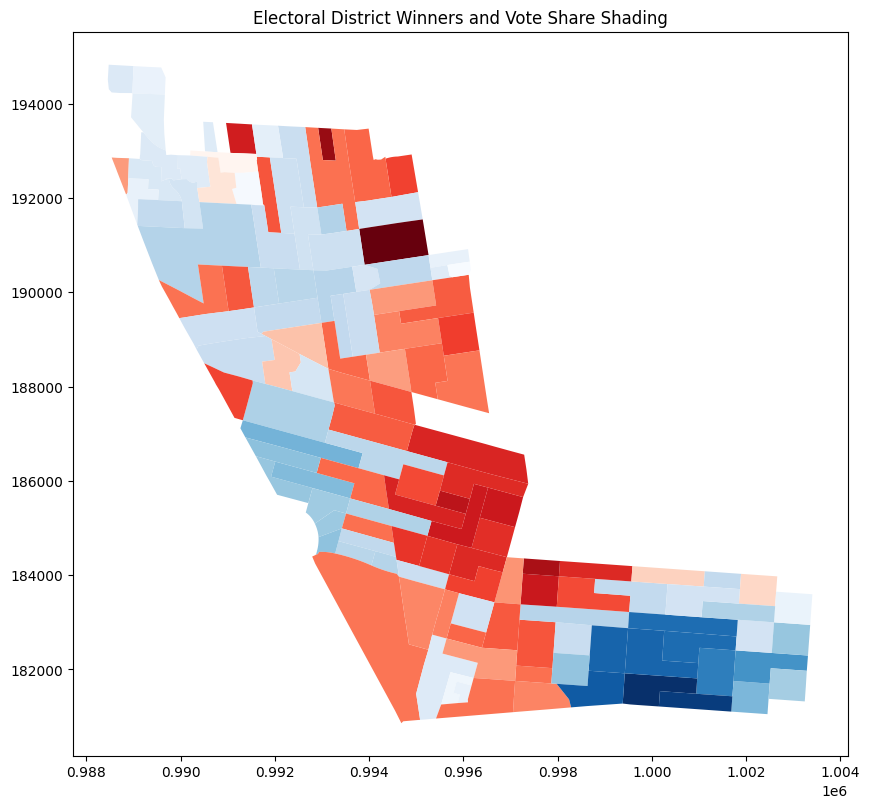

In [97]:
fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [124]:
d35['ed_total_votes'] = d35.groupby('ed_name')['ed_name'].transform('count')

In [126]:
pc = make_precinct_counts(d35,'district_35','Crystal Hudson','Michael Hollingsworth')

In [131]:
pc

,Precinct,Crystal Hudson_Michael Hollingsworth,Crystal Hudson_notMichael Hollingsworth,Michael Hollingsworth_Crystal Hudson,Michael Hollingsworth_notCrystal Hudson,neither,biggest,AD,ED,ed_name,total_votes
0,AD: 43 ED: 013,2,164,14,6,59,Crystal Hudson_notMichael Hollingsworth,43,013,43013,245
1,AD: 43 ED: 035,35,38,50,58,98,Michael Hollingsworth_notCrystal Hudson,43,035,43035,279
2,AD: 43 ED: 036,22,34,38,53,74,Michael Hollingsworth_notCrystal Hudson,43,036,43036,221
3,AD: 43 ED: 037,25,40,41,79,87,Michael Hollingsworth_notCrystal Hudson,43,037,43037,272
4,AD: 43 ED: 038,20,101,25,44,118,Crystal Hudson_notMichael Hollingsworth,43,038,43038,308
...,...,...,...,...,...,...,...,...,...,...,...
126,AD: 57 ED: 097,2,19,6,8,50,Crystal Hudson_notMichael Hollingsworth,57,097,57097,85
127,AD: 57 ED: 098,5,31,4,8,60,Crystal Hudson_notMichael Hollingsworth,57,098,57098,108
128,AD: 57 ED: 103,47,55,71,75,84,Michael Hollingsworth_notCrystal Hudson,57,103,57103,332
129,AD: 57 ED: 104,100,62,132,88,67,Michael Hollingsworth_Crystal Hudson,57,104,57104,449


In [130]:
# sum numbers from col 2 to 5
pc['total_votes'] = pc.iloc[:, 1:6].sum(axis=1)

In [134]:
pc = make_precinct_counts(d35,'district_35','Crystal Hudson','Michael Hollingsworth')
pc['total_votes'] = pc.iloc[:, 1:6].sum(axis=1)
pc = pc[['ed_name','Crystal Hudson_notMichael Hollingsworth','total_votes']]
pc.columns = ['ed_name','ch_notmh','total']
pc['ch_vote_share'] = pc['ch_notmh'] / pc['total']
el = full_results_thirty_five[full_results_thirty_five['winner'] == True]
map = pc.merge(el[['ed_name','geometry']],on='ed_name', how='left')
map = gpd.GeoDataFrame(map,geometry=map['geometry'].apply(wkt.loads))

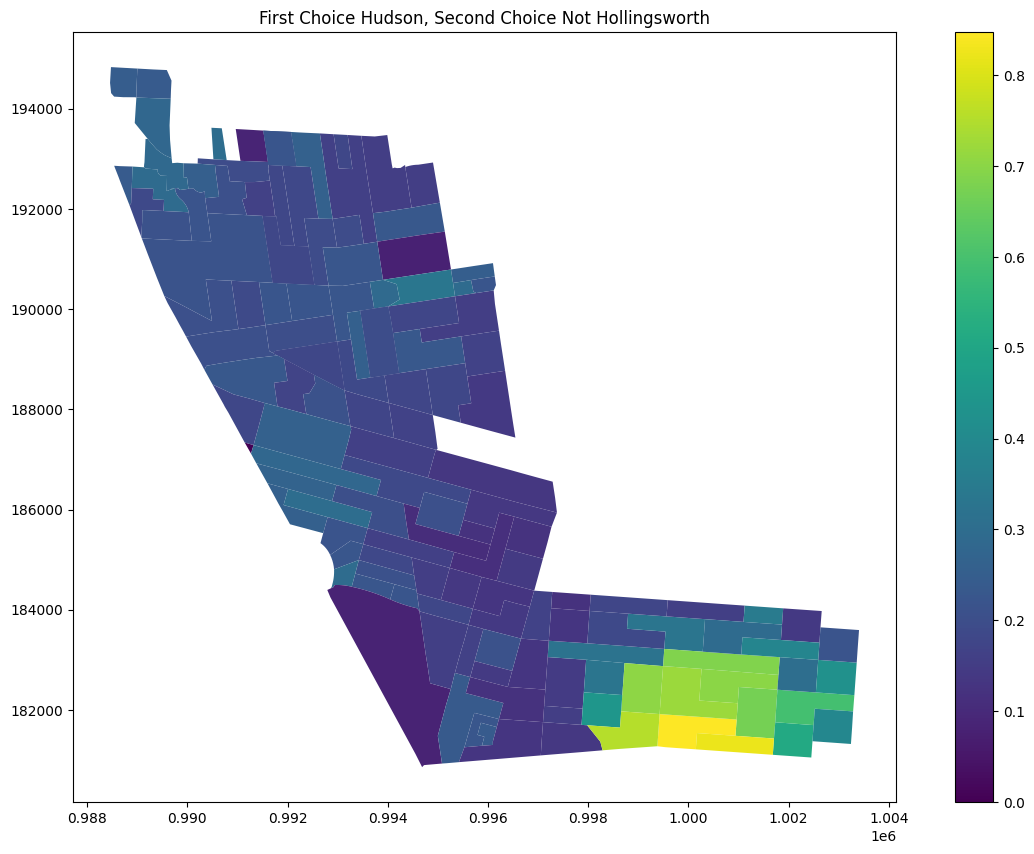

In [135]:
map.plot(column='ch_vote_share', cmap='viridis', legend=True, figsize=(15, 10))
plt.title("First Choice Hudson, Second Choice Not Hollingsworth")
plt.show()